# Modelo MLP para clasificación en CIFAR-100

## Importaciones

In [76]:
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import HeNormal
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

## 1. Cargar datos CIFAR-100 (Solo fine)

In [19]:
(x_train, y_train_fine), (x_test, y_test_fine) = cifar100.load_data(label_mode='fine')

## 2. Normalizar imágenes

In [20]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

### Aplanar imagenes

In [21]:
x_train = x_train.reshape((x_train.shape[0], -1))
x_test = x_test.reshape((x_test.shape[0], -1))

## 3. One-hot encoding para las clases finas

In [22]:
y_train_fine = to_categorical(y_train_fine, 100)
y_test_fine = to_categorical(y_test_fine, 100)

## 4. Diccionario para mapear clases finas a superclases

In [23]:
def get_fine_labels():
    return [
        'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 
        'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 
        'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 
        'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 
        'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 
        'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
        'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
        'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
        'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
        'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
        'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
        'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
        'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
        'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
        'worm'
    ]

fine_labels = get_fine_labels()

class_mapping = {
    'aquatic mammals': ['beaver', 'dolphin', 'otter', 'seal', 'whale'],
    'fish': ['aquarium_fish', 'flatfish', 'ray', 'shark', 'trout'],
    'flowers': ['orchid', 'poppy', 'rose', 'sunflower', 'tulip'],
    'food containers': ['bottle', 'bowl', 'can', 'cup', 'plate'],
    'fruit and vegetables': ['apple', 'mushroom', 'orange', 'pear', 'sweet_pepper'], 
    'household electrical devices': ['clock', 'keyboard', 'lamp', 'telephone', 'television'],
    'household furniture': ['bed', 'chair', 'couch', 'table', 'wardrobe'],
    'insects': ['bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach'],
    'large carnivores': ['bear', 'leopard', 'lion', 'tiger', 'wolf'],
    'large man-made outdoor things': ['bridge', 'castle', 'house', 'road', 'skyscraper'],
    'large natural outdoor scenes': ['cloud', 'forest', 'mountain', 'plain', 'sea'],
    'large omnivores and herbivores': ['camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo'],
    'medium-sized mammals': ['fox', 'porcupine', 'possum', 'raccoon', 'skunk'],
    'non-insect invertebrates': ['crab', 'lobster', 'snail', 'spider', 'worm'],
    'people': ['baby', 'boy', 'girl', 'man', 'woman'],
    'reptiles': ['crocodile', 'dinosaur', 'lizard', 'snake', 'turtle'],
    'small mammals': ['hamster', 'mouse', 'rabbit', 'shrew', 'squirrel'],
    'trees': ['maple_tree', 'oak_tree', 'palm_tree', 'pine_tree', 'willow_tree'],
    'vehicles 1': ['bicycle', 'bus', 'motorcycle', 'pickup_truck', 'train'],
    'vehicles 2': ['lawn_mower', 'rocket', 'streetcar', 'tank', 'tractor']
}

fine_to_coarse = {}
coarse_labels = list(class_mapping.keys())

for coarse_idx, (coarse_name, fine_names) in enumerate(class_mapping.items()):
    for fine_name in fine_names:
        try:
            fine_idx = fine_labels.index(fine_name)
            fine_to_coarse[fine_idx] = coarse_idx
        except ValueError as e:
            print(f"Advertencia: No se encontró '{fine_name}' en fine_labels. Error: {e}")

# Verificación
print(f"\nMapeo creado para {len(fine_to_coarse)} de {len(fine_labels)} clases finas")
print("Ejemplo de mapeo:")
for i in range(5):
    fine_idx = list(fine_to_coarse.keys())[i]
    print(f"{fine_labels[fine_idx]} (índice {fine_idx}) -> {coarse_labels[fine_to_coarse[fine_idx]]}")


Mapeo creado para 100 de 100 clases finas
Ejemplo de mapeo:
beaver (índice 4) -> aquatic mammals
dolphin (índice 30) -> aquatic mammals
otter (índice 55) -> aquatic mammals
seal (índice 72) -> aquatic mammals
whale (índice 95) -> aquatic mammals


## 5. Construir modelo MLP

In [67]:
model = Sequential([
    Dense(2048, activation='swish', kernel_initializer=HeNormal(), kernel_regularizer=l2(1e-4), input_shape=(3072,)),
    BatchNormalization(),
    Dropout(0.4),
    
    Dense(1024, activation='swish', kernel_initializer=HeNormal(), kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Dropout(0.4),
    
    Dense(512, activation='swish', kernel_initializer=HeNormal(), kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(256, activation='swish', kernel_initializer=HeNormal(), kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    
    Dense(100, activation='softmax')
])

# Optimizador mejorado
optimizer = Nadam(learning_rate=1e-3, clipnorm=1.0)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Programación de tasa de aprendizaje
def lr_schedule(epoch):
    if epoch < 20:
        return 1e-3
    elif epoch < 50:
        return 5e-4
    elif epoch < 80:
        return 1e-4
    else:
        return 5e-5

lr_scheduler = LearningRateScheduler(lr_schedule)

## 6. Callbacks

In [71]:
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True),
    ModelCheckpoint('best_model_cifar100_mlp.keras', save_best_only=True),
    LearningRateScheduler(lr_schedule)
]

### Generador de datos aumentados

In [69]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.1,
    preprocessing_function=lambda x: x.reshape(-1)
)

train_generator = datagen.flow(
    x_train.reshape(-1, 32, 32, 3),
    y_train_fine,
    batch_size=128,
    subset='training'
)

val_generator = datagen.flow(
    x_train.reshape(-1, 32, 32, 3),
    y_train_fine,
    batch_size=128,
    subset='validation'
)

## 7. Entrenar el modelo

In [74]:
history = model.fit(
    x_train, y_train_fine,
    batch_size=128,
    epochs=150,
    validation_split=0.25,
    callbacks=callbacks
)

Epoch 1/150
293/293 ━━━━━━━━━━━━━━━━━━━━ 54s 183ms/step - accuracy: 0.1169 - loss: 4.5952 - val_accuracy: 0.1311 - val_loss: 4.3504 - learning_rate: 0.0010
Epoch 2/150
293/293 ━━━━━━━━━━━━━━━━━━━━ 62s 211ms/step - accuracy: 0.1558 - loss: 4.2086 - val_accuracy: 0.1032 - val_loss: 4.4339 - learning_rate: 0.0010
Epoch 3/150
293/293 ━━━━━━━━━━━━━━━━━━━━ 66s 225ms/step - accuracy: 0.1684 - loss: 4.0216 - val_accuracy: 0.1390 - val_loss: 4.1484 - learning_rate: 0.0010
Epoch 4/150
293/293 ━━━━━━━━━━━━━━━━━━━━ 60s 205ms/step - accuracy: 0.1819 - loss: 3.8739 - val_accuracy: 0.1258 - val_loss: 4.2327 - learning_rate: 0.0010
Epoch 5/150
293/293 ━━━━━━━━━━━━━━━━━━━━ 55s 188ms/step - accuracy: 0.1936 - loss: 3.8022 - val_accuracy: 0.1588 - val_loss: 4.0282 - learning_rate: 0.0010
Epoch 6/150
293/293 ━━━━━━━━━━━━━━━━━━━━ 55s 188ms/step - accuracy: 0.1940 - loss: 3.7450 - val_accuracy: 0.1542 - val_loss: 4.0098 - learning_rate: 0.0010
Epoch 7/150
293/293 ━━━━━━━━━━━━━━━━━━━━ 65s 221ms/step - accura

## 8. Función para predecir y convertir a superclases

### 1. Gráficos de Rendimiento del Entrenamiento (para clases finas)

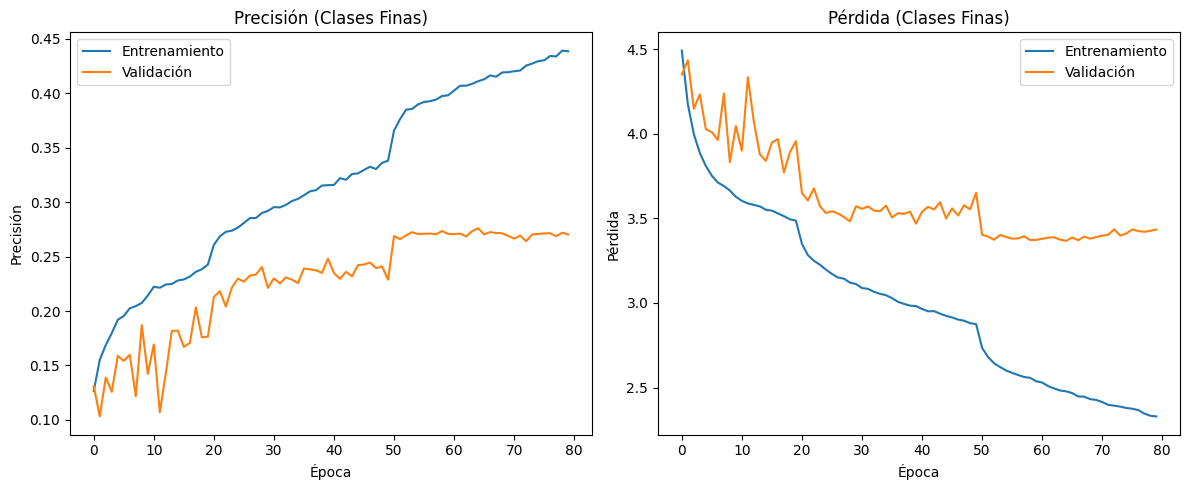

In [79]:
import matplotlib.pyplot as plt

def plot_training_history_fine(history):
    plt.figure(figsize=(12, 5))
    
    # Gráfico de precisión
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Validación')
    plt.title('Precisión (Clases Finas)')
    plt.ylabel('Precisión')
    plt.xlabel('Época')
    plt.legend()
    
    # Gráfico de pérdida
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Entrenamiento')
    plt.plot(history.history['val_loss'], label='Validación')
    plt.title('Pérdida (Clases Finas)')
    plt.ylabel('Pérdida')
    plt.xlabel('Época')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_training_history_fine(history)

### 2. Función Mejorada de Predicción

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


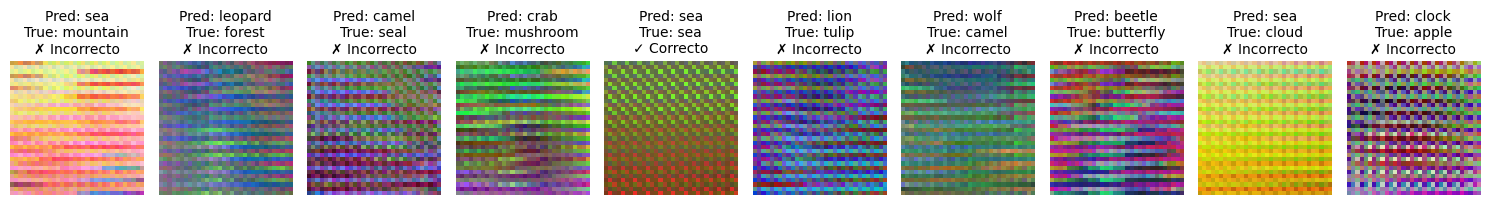

In [86]:
def predict_and_visualize_fine(model, images, true_labels=None, num_images=5):
    # Realizar predicciones
    fine_probs = model.predict(images)
    fine_preds = np.argmax(fine_probs, axis=1)
    
    # Obtener nombres de clases
    predicted_labels = [fine_labels[pred] for pred in fine_preds]
    
    # Mostrar imágenes con predicciones
    plt.figure(figsize=(15, 8))
    for i in range(min(num_images, len(images))):
        plt.subplot(1, num_images, i+1)
        
        # Reformatear la imagen si es necesario (para CIFAR-100)
        if images[i].shape == (3072,) or images[i].shape == (32*32*3,):
            # Reorganizar de (3072,) a (3, 32, 32) y luego a (32, 32, 3)
            img_reshaped = images[i].reshape(3, 32, 32).transpose(1, 2, 0)
            plt.imshow(img_reshaped)
        else:
            # Si ya tiene la forma correcta, mostrarla directamente
            plt.imshow(images[i])
        
        # Configurar título
        title = f"Pred: {predicted_labels[i]}"
        
        # Si tenemos las etiquetas verdaderas
        if true_labels is not None:
            # Manejar tanto one-hot como índices directos
            if hasattr(true_labels[i], 'argmax'):  # Si es one-hot
                true_label_idx = true_labels[i].argmax()
            else:  # Si ya es un índice
                true_label_idx = true_labels[i]
                
            true_label = fine_labels[true_label_idx]
            title += f"\nTrue: {true_label}"
            
            # Resaltar si la predicción es correcta
            if true_label_idx == fine_preds[i]:
                title += "\n✓ Correcto"
            else:
                title += "\n✗ Incorrecto"
        
        plt.title(title, fontsize=10)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return fine_preds

# Ejemplo de uso
fine_preds = predict_and_visualize_fine(
    model, 
    x_test[:10], 
    true_labels=y_test_fine[:10],
    num_images=10
)

### 3. Matriz de Confusión para Clases Finas

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


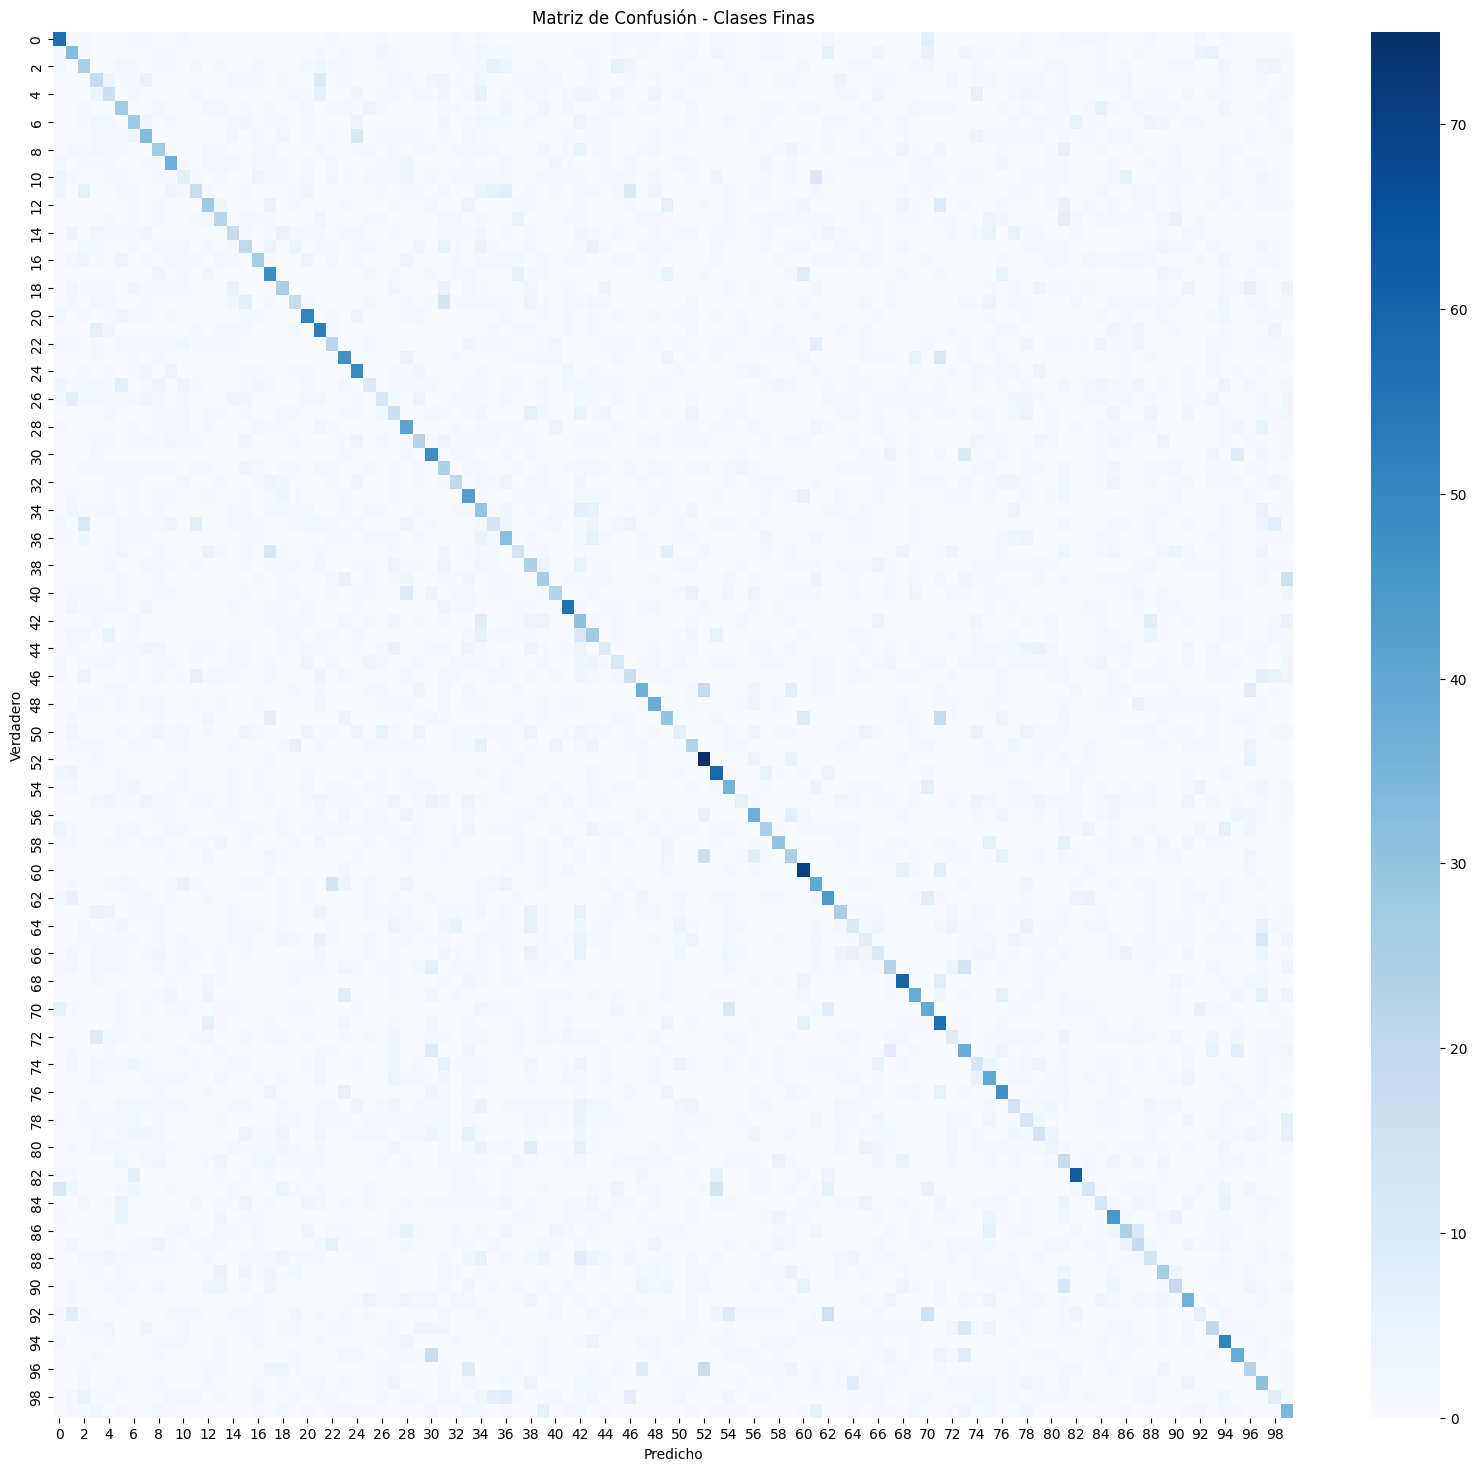

In [81]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_fine_confusion_matrix(y_true, y_pred, figsize=(20, 18)):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
    plt.title('Matriz de Confusión - Clases Finas')
    plt.ylabel('Verdadero')
    plt.xlabel('Predicho')
    plt.show()

# Para clases finas
y_test_fine_labels = np.argmax(y_test_fine, axis=1) if len(y_test_fine.shape) > 1 else y_test_fine
y_pred_fine_labels = np.argmax(model.predict(x_test), axis=1)
plot_fine_confusion_matrix(y_test_fine_labels, y_pred_fine_labels)

### 4. Reporte de Clasificación Detallado

In [82]:
from sklearn.metrics import classification_report

def print_fine_classification_report(y_true, y_pred, top_n=10):
    # Convertir one-hot encoding a índices si es necesario
    y_true_labels = np.argmax(y_true, axis=1) if len(y_true.shape) > 1 else y_true
    y_pred_labels = y_pred
    
    # Reporte completo
    print("\nREPORTE DE CLASIFICACIÓN COMPLETO:")
    print("="*60)
    print(classification_report(y_true_labels, y_pred_labels, target_names=fine_labels, zero_division=0))
    
    # Reporte resumido (top n clases con peor precisión)
    report = classification_report(y_true_labels, y_pred_labels, target_names=fine_labels, output_dict=True, zero_division=0)
    sorted_classes = sorted(report.items(), key=lambda x: x[1]['precision'] if isinstance(x[1], dict) else 0)
    
    print("\nTOP {} CLASES CON PEOR PRECISIÓN:".format(top_n))
    print("="*60)
    for class_name, metrics in sorted_classes[:top_n]:
        if isinstance(metrics, dict):
            print(f"{class_name}: Precision={metrics['precision']:.2f}, Recall={metrics['recall']:.2f}, F1={metrics['f1-score']:.2f}")

# Ejemplo de uso
print_fine_classification_report(y_test_fine, y_pred_fine_labels)


REPORTE DE CLASIFICACIÓN COMPLETO:
               precision    recall  f1-score   support

        apple       0.47      0.57      0.52       100
aquarium_fish       0.29      0.33      0.31       100
         baby       0.26      0.25      0.25       100
         bear       0.17      0.18      0.18       100
       beaver       0.17      0.16      0.16       100
          bed       0.23      0.27      0.25       100
          bee       0.27      0.28      0.27       100
       beetle       0.32      0.33      0.32       100
      bicycle       0.24      0.27      0.25       100
       bottle       0.37      0.37      0.37       100
         bowl       0.12      0.07      0.09       100
          boy       0.30      0.17      0.22       100
       bridge       0.32      0.28      0.30       100
          bus       0.28      0.22      0.24       100
    butterfly       0.29      0.19      0.23       100
        camel       0.20      0.20      0.20       100
          can       0.32    

### 5. Análisis de Errores Comunes

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step

ERRORES MÁS COMUNES:
Verdadero: mountain -> Predicho: sea (Ocurrencias: 18)
Verdadero: maple_tree -> Predicho: oak_tree (Ocurrencias: 18)
Verdadero: whale -> Predicho: dolphin (Ocurrencias: 17)
Verdadero: willow_tree -> Predicho: oak_tree (Ocurrencias: 17)
Verdadero: pine_tree -> Predicho: oak_tree (Ocurrencias: 17)

EJEMPLOS DE ERRORES:


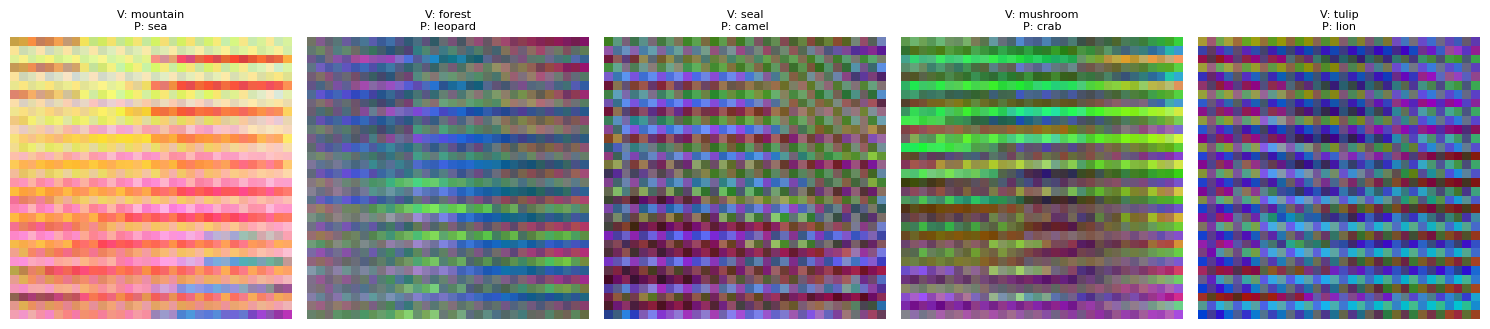


CLASES CON MÁS ERRORES:
squirrel: 96 errores
otter: 94 errores
tulip: 93 errores
mouse: 93 errores
bowl: 93 errores


In [87]:
def analyze_fine_errors(model, x_test, y_test_fine, top_n=5):
    # Obtener predicciones
    y_test_labels = np.argmax(y_test_fine, axis=1) if len(y_test_fine.shape) > 1 else y_test_fine
    y_pred_labels = np.argmax(model.predict(x_test), axis=1)
    
    # Identificar errores
    errors = []
    for i in range(len(y_test_labels)):
        if y_test_labels[i] != y_pred_labels[i]:
            true_label = fine_labels[y_test_labels[i]]
            pred_label = fine_labels[y_pred_labels[i]]
            errors.append((true_label, pred_label, x_test[i]))
    
    # Contar errores más comunes
    error_counts = {}
    for error in errors:
        key = (error[0], error[1])
        error_counts[key] = error_counts.get(key, 0) + 1
    
    # Ordenar errores por frecuencia
    sorted_errors = sorted(error_counts.items(), key=lambda x: x[1], reverse=True)[:top_n]
    
    # Mostrar errores más comunes
    print("\nERRORES MÁS COMUNES:")
    print("="*50)
    for (true, pred), count in sorted_errors:
        print(f"Verdadero: {true} -> Predicho: {pred} (Ocurrencias: {count})")
    
    # Visualizar algunos errores
    print("\nEJEMPLOS DE ERRORES:")
    plt.figure(figsize=(15, 8))
    for i in range(min(5, len(errors))):
        plt.subplot(1, 5, i+1)
        
        # Reformatear la imagen si es necesario (para CIFAR-100)
        if errors[i][2].shape == (3072,) or errors[i][2].shape == (32*32*3,):
            # Reorganizar de (3072,) a (3, 32, 32) y luego a (32, 32, 3)
            img_reshaped = errors[i][2].reshape(3, 32, 32).transpose(1, 2, 0)
            plt.imshow(img_reshaped)
        else:
            # Si ya tiene la forma correcta, mostrarla directamente
            plt.imshow(errors[i][2])
            
        plt.title(f"V: {errors[i][0]}\nP: {errors[i][1]}", fontsize=8)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Análisis de clases con más errores
    class_errors = {}
    for true, pred, _ in errors:
        class_errors[true] = class_errors.get(true, 0) + 1
    
    sorted_class_errors = sorted(class_errors.items(), key=lambda x: x[1], reverse=True)[:top_n]
    print("\nCLASES CON MÁS ERRORES:")
    print("="*50)
    for class_name, count in sorted_class_errors:
        print(f"{class_name}: {count} errores")

# Ejemplo de uso
analyze_fine_errors(model, x_test, y_test_fine)

### 6. Gráfico de Precisión por Clase

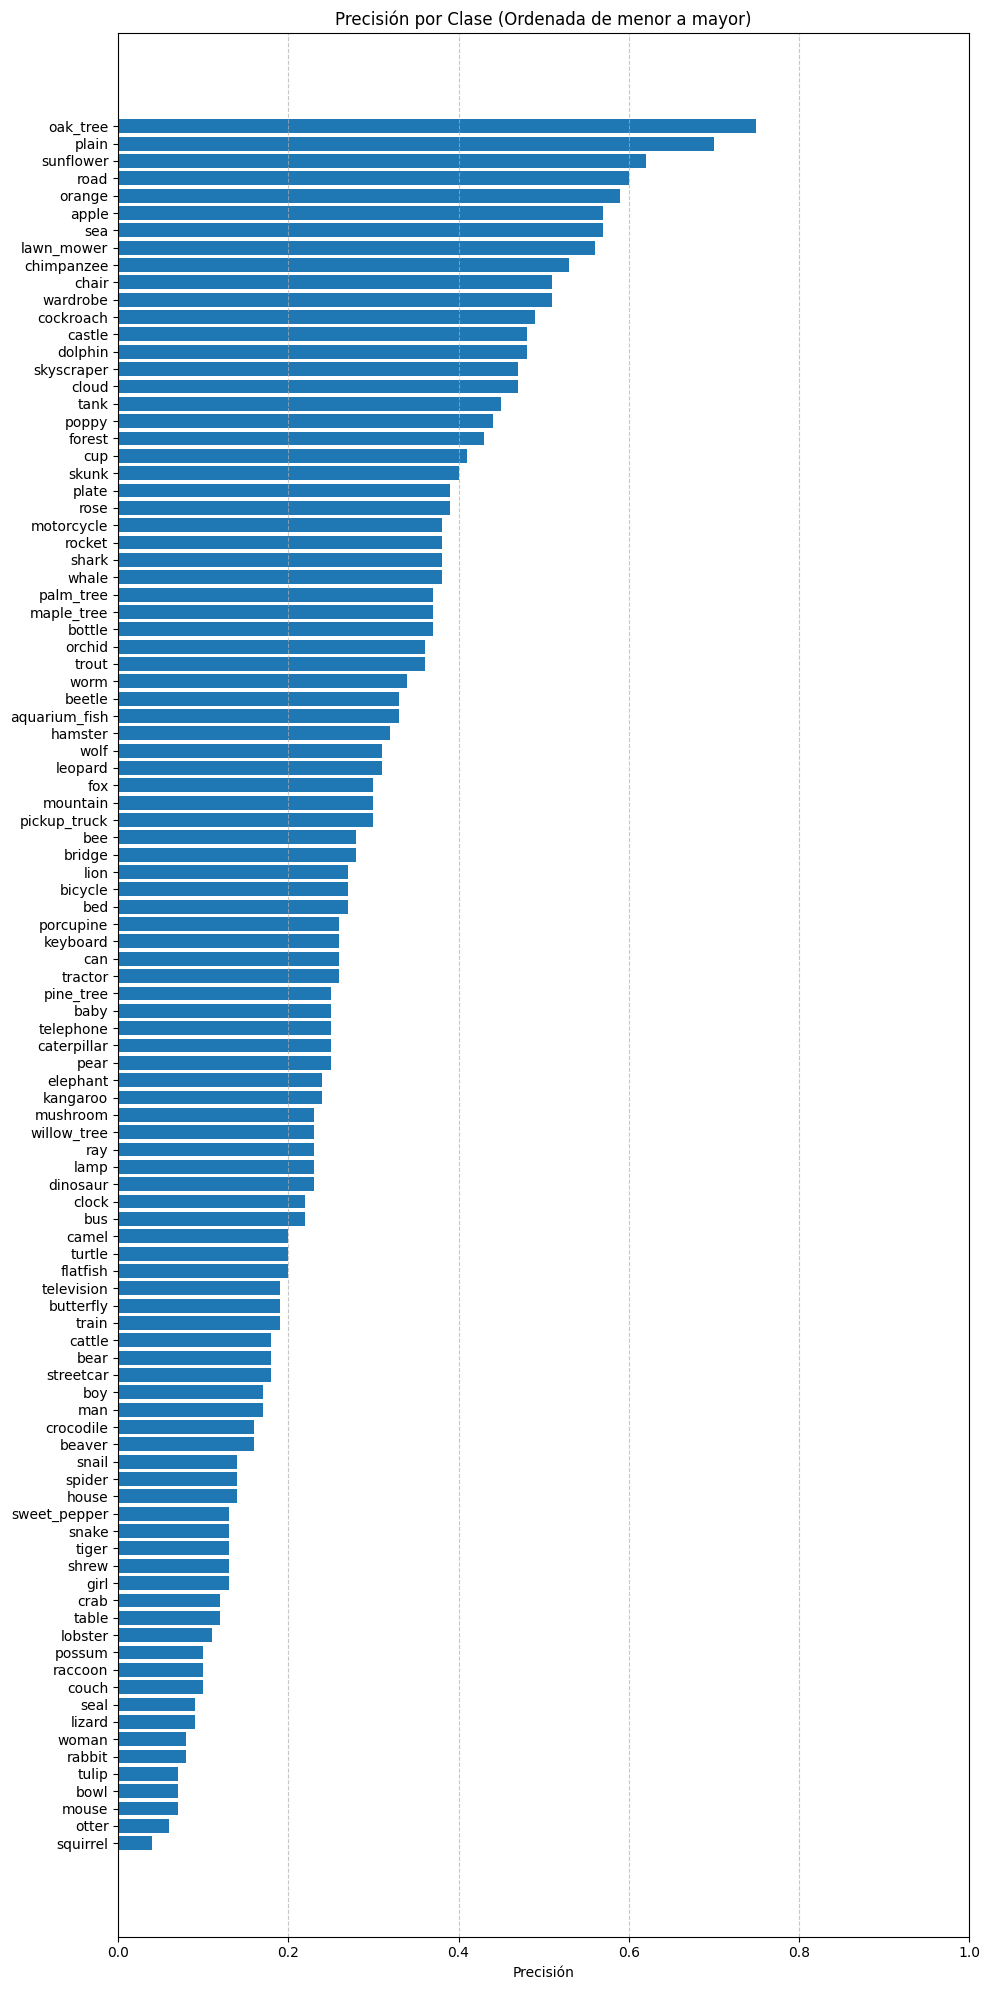

In [84]:
def plot_class_accuracy(y_true, y_pred):
    # Calcular precisión por clase
    cm = confusion_matrix(y_true, y_pred)
    class_accuracy = cm.diagonal() / cm.sum(axis=1)
    
    # Ordenar clases por precisión
    sorted_indices = np.argsort(class_accuracy)
    sorted_accuracy = class_accuracy[sorted_indices]
    sorted_labels = [fine_labels[i] for i in sorted_indices]
    
    # Crear gráfico
    plt.figure(figsize=(10, 20))
    plt.barh(sorted_labels, sorted_accuracy)
    plt.xlabel('Precisión')
    plt.title('Precisión por Clase (Ordenada de menor a mayor)')
    plt.xlim([0, 1])
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Ejemplo de uso
plot_class_accuracy(y_test_fine_labels, y_pred_fine_labels)